In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Setup & Configuration
Run this cell first to initialize imports, paths, and experiment settings.

In [5]:
import sys
import os
import importlib
from pathlib import Path

# Determine the workspace kari directory (where this notebook is located)
# The notebook is at: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari/kari.ipynb
# So the workspace kari directory is: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari
workspace_root = '/home/dsi/eli-bogdanov/sktr_for_long_traces'
workspace_kari_dir = os.path.join(workspace_root, 'kari')

# Verify it exists and has utils.py
if os.path.exists(workspace_kari_dir) and os.path.exists(os.path.join(workspace_kari_dir, 'utils.py')):
    notebook_dir = workspace_kari_dir
else:
    # Fallback: try to infer from current directory
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == 'kari' and os.path.exists(os.path.join(current_dir, 'utils.py')):
        notebook_dir = current_dir
    else:
        # Try parent/kari
        parent_kari = os.path.join(os.path.dirname(current_dir), 'kari')
        if os.path.exists(parent_kari) and os.path.exists(os.path.join(parent_kari, 'utils.py')):
            notebook_dir = parent_kari
        else:
            notebook_dir = current_dir  # Last resort

# Remove any conflicting kari directories from sys.path
# Specifically remove /home/dsi/eli-bogdanov/kari if it exists
conflicting_paths = [
    '/home/dsi/eli-bogdanov/kari',
    os.path.join(os.path.expanduser('~'), 'kari'),
]
for path in conflicting_paths:
    abs_path = os.path.abspath(path)
    if abs_path in sys.path:
        sys.path.remove(abs_path)
        print(f"   Removed conflicting path: {abs_path}")

# Ensure the workspace kari directory is FIRST in sys.path (highest priority)
if notebook_dir not in sys.path:
    sys.path.insert(0, notebook_dir)
elif sys.path.index(notebook_dir) != 0:
    # Move to front if it exists but isn't first
    sys.path.remove(notebook_dir)
    sys.path.insert(0, notebook_dir)

# Add current directory to sys.path for local modules (but with lower priority)
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

# If running from parent directory, also add kari subdirectory (but with lower priority)
kari_dir = os.path.join(current_dir, 'kari')
if os.path.basename(current_dir) != 'kari' and os.path.exists(kari_dir):
    if kari_dir not in sys.path:
        sys.path.append(kari_dir)  # Append instead of insert to give lower priority

# Clear any cached utils module to force reimport from correct location
if 'utils' in sys.modules:
    del sys.modules['utils']
    print("   Cleared cached 'utils' module")

# Diagnostic: Check which utils.py will be imported
import importlib.util
utils_paths = []
for path_dir in sys.path:
    potential_utils = os.path.join(path_dir, 'utils.py')
    if os.path.exists(potential_utils):
        utils_paths.append(potential_utils)

print("🔍 Import path diagnostics:")
print(f"   Current working directory: {current_dir}")
print(f"   Notebook directory (workspace kari): {notebook_dir}")
print(f"   Found utils.py files:")
for i, upath in enumerate(utils_paths):
    marker = " ⭐ (will be imported)" if i == 0 else ""
    print(f"      {i+1}. {upath}{marker}")
print(f"   sys.path order (first 5):")
for i, spath in enumerate(sys.path[:5]):
    print(f"      {i+1}. {spath}")

import pandas as pd
import pickle as pkl
import json
import numpy as np
from datetime import datetime
from types import SimpleNamespace

# Import local modules
try:
    from utils import read_grammar, read_mapping_dict, compute_parser_accuracy
    # Verify we imported from the right file
    import utils
    actual_utils_path = utils.__file__
    expected_utils_path = os.path.join(notebook_dir, 'utils.py')
    if os.path.abspath(actual_utils_path) != os.path.abspath(expected_utils_path):
        print(f"⚠️  WARNING: Imported utils from {actual_utils_path}")
        print(f"   Expected: {expected_utils_path}")
    else:
        print(f"✅ Imported utils from correct location: {actual_utils_path}")
    
    import bep as BEP
    from trace_sampler import sample_and_prepare_for_kari
    from run_tag_utils import prepare_run_dirs
    from kari import get_grammar
except ImportError as e:
    print(f"Error importing modules: {e}")
    raise

# =========================
# Experiment Settings
# =========================

# Dataset selection
dataset = '50salads'  # Options: '50salads', 'breakfast', 'gtea'

# Hyperparameters (matching hyperparameter_search.ipynb)
random_seed = 101
ensure_train_variant_diversity = True
allow_train_cases_in_test = True

# Sweep Configuration
TRAIN_TRACE_SWEEP = {
    '50salads': list(range(10, 0, -1)),
    'gtea': list(range(7, 0, -1)),
    'breakfast': list(range(10, 0, -1))
}
sweep_values = TRAIN_TRACE_SWEEP.get(dataset, [5])

# Parallelization Configuration (similar to hyperparameter_search.ipynb)
# MEMORY OPTIMIZATION: Reduce parallel jobs to avoid OOM errors
# Each worker loads the entire matrices_file, so 4 workers = 4x memory usage
# Set to 1 for sequential processing (safest), 2 for limited parallelism
PARALLEL_N_JOBS = 1  # Number of parallel jobs for the sweep; reduce if you hit OOM (1=sequential)
PARALLEL_VERBOSE = 10  # Verbosity level for joblib (0=silent, 10=all)

# Grammar Settings
# According to KARI paper: N_key (topK) values for key action selection
# - Breakfast: N_key = 4 (use topK with K=4)
# - 50 Salads: N_key = 3 (use topK with K=3)
# - GTEA: Not specified in paper, default to False
if dataset == 'breakfast':
    use_topK = True
    topK_K = 4
elif dataset == '50salads':
    use_topK = False
    topK_K =  3
else:  # gtea or others
    use_topK = False
    topK_K = 3  # Default value (not used when use_topK=False)

# Determine kari directory (where this notebook is located)
# Use the notebook_dir we already determined (workspace kari directory)
kari_base_dir = notebook_dir

# Paths (all relative to workspace root)
# Resolve base_video_dir relative to workspace root, not current working directory
base_video_dir = os.path.join(workspace_root, 'Datasets', 'video')
# If that doesn't exist, try relative to kari_base_dir
if not os.path.exists(base_video_dir):
    base_video_dir_rel = os.path.join(os.path.dirname(kari_base_dir), 'Datasets', 'video')
    if os.path.exists(base_video_dir_rel):
        base_video_dir = base_video_dir_rel
    else:
        # Try common alternative locations
        alt_paths = [
            os.path.join(os.path.expanduser('~'), 'Datasets', 'video'),
            os.path.join('/home', 'dsi', 'eli-bogdanov', 'Datasets', 'video'),
        ]
        for alt_path in alt_paths:
            if os.path.exists(alt_path):
                base_video_dir = alt_path
                break

# Helper: prefer streaming manifest/dir if available, else fall back to pickle

def select_matrices(base_dir, name):
    stream_dir = os.path.join(base_dir, f"{name}_softmax_stream")
    manifest = os.path.join(stream_dir, "manifest.json")
    pickle_path = os.path.join(base_dir, f"{name}_softmax_lst.pickle")
    if os.path.exists(manifest):
        return manifest
    if os.path.isdir(stream_dir):
        return stream_dir
    return pickle_path

# Dataset-specific paths
if dataset == '50salads':
    log_csv = os.path.join(base_video_dir, '50salads_log.csv')
    matrices_file = select_matrices(base_video_dir, '50salads')
    source_dir = os.path.join(kari_base_dir, 'source_50salads')
    sample_stride, qsize, str_len = 100, 20, 25
elif dataset == 'breakfast':
    log_csv = os.path.join(base_video_dir, 'breakfast_log.csv')
    matrices_file = select_matrices(base_video_dir, 'breakfast')
    source_dir = os.path.join(kari_base_dir, 'source_breakfast')
    sample_stride, qsize, str_len = 50, 20, 25
elif dataset == 'gtea':
    log_csv = os.path.join(base_video_dir, 'gtea_log.csv')
    matrices_file = select_matrices(base_video_dir, 'gtea')
    source_dir = os.path.join(kari_base_dir, 'source_gtea')
    # GTEA parameters: stride=30 (balanced between Breakfast's 50 and aggressive 20), qsize=20, str_len=50 (covers max 41 segments)
    sample_stride, qsize, str_len = 30, 20, 50
else:
    raise ValueError(f"Unknown dataset: {dataset}")

mapping_file = os.path.join(source_dir, 'mapping.txt')
run_config = {
    "dataset": dataset,
    "random_seed": random_seed,
    "ensure_train_variant_diversity": ensure_train_variant_diversity,
    "allow_train_cases_in_test": allow_train_cases_in_test,
    "use_topK": use_topK,
    "topK_K": topK_K,
    "sample_stride": sample_stride,
    "qsize": qsize,
    "str_len": str_len,
    "parallel_n_jobs": PARALLEL_N_JOBS,
    "parallel_verbose": PARALLEL_VERBOSE,
    "sweep_values": sweep_values,
    "n_train_values": sweep_values,
}
run_tag, results_dir, grammar_result_root = prepare_run_dirs(
    base_dir=Path(kari_base_dir),
    dataset=dataset,
    use_topK=use_topK,
    topK_K=topK_K,
    config=run_config,
)

# Verify critical paths exist
print(f"\n✅ Configuration Loaded:")
print(f"   Dataset: {dataset}")
print(f"   Sweep Values (n_train): {sweep_values}")
print(f"   Random Seed: {random_seed}")
print(f"   Kari Base Dir: {kari_base_dir}")
print(f"   Grammar Dir: {grammar_result_root}")
print(f"   Run Tag: {run_tag}")
print(f"   Results Dir: {results_dir}")
print(f"   Source Dir: {source_dir}")
print(f"   Base Video Dir: {base_video_dir}")
print(f"   Log CSV: {log_csv}")
print(f"   Matrices File: {matrices_file}")

# Verify files exist
if not os.path.exists(log_csv):
    print(f"\n⚠️  WARNING: log_csv not found: {log_csv}")
if not os.path.exists(matrices_file):
    print(f"\n⚠️  WARNING: matrices_file not found: {matrices_file}")
if not os.path.exists(source_dir):
    print(f"\n⚠️  WARNING: source_dir not found: {source_dir}")
    print(f"   Creating source_dir...")
    os.makedirs(source_dir, exist_ok=True)

   Cleared cached 'utils' module
🔍 Import path diagnostics:
   Current working directory: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari
   Notebook directory (workspace kari): /home/dsi/eli-bogdanov/sktr_for_long_traces/kari
   Found utils.py files:
      1. /home/dsi/eli-bogdanov/sktr_for_long_traces/kari/utils.py ⭐ (will be imported)
      2. utils.py
   sys.path order (first 5):
      1. /home/dsi/eli-bogdanov/sktr_for_long_traces/kari
      2. /usr/lib64/python39.zip
      3. /usr/lib64/python3.9
      4. /usr/lib64/python3.9/lib-dynload
      5. 
✅ Imported utils from correct location: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari/utils.py

✅ Configuration Loaded:
   Dataset: 50salads
   Sweep Values (n_train): [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
   Random Seed: 101
   Kari Base Dir: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari
   Grammar Dir: /home/dsi/eli-bogdanov/sktr_for_long_traces/kari/results/induced_grammars_experiment/50salads/20251203
   Run Tag: 20251203
   Result

# 2. Main Experiment Loop
This cell iterates through the sweep values, performs sampling, induces grammar, and runs the parser.

In [ ]:
from pathlib import Path
from joblib import Parallel, delayed
import shutil
import gc

# Load the log data once (shared across all parallel workers)
df = pd.read_csv(log_csv)

# MEMORY OPTIMIZATION: Add memory monitoring helper
def get_memory_usage_mb():
    """Get current memory usage in MB"""
    try:
        import psutil
        process = psutil.Process()
        return process.memory_info().rss / 1024 / 1024
    except ImportError:
        return None


def run_single_kari_experiment(
    n_train,
    idx,
    total_runs,
    df,
    dataset,
    source_dir,
    random_seed,
    ensure_train_variant_diversity,
    allow_train_cases_in_test,
    use_topK,
    topK_K,
    grammar_result_root,
    results_dir,
    mapping_file,
    matrices_file,
    sample_stride,
    qsize,
    str_len,
    kari_base_dir,
):
    """
    Run a single KARI experiment for a given n_train value.
    This function is designed to be called in parallel via joblib.
    """
    # Re-import necessary modules inside the function for worker process compatibility
    import sys
    import os
    import shutil
    import pickle as pkl
    import gc
    from types import SimpleNamespace
    from datetime import datetime
    
    # MEMORY OPTIMIZATION: Helper function for memory monitoring (defined inside for parallel workers)
    def get_memory_usage_mb():
        """Get current memory usage in MB"""
        try:
            import psutil
            process = psutil.Process()
            return process.memory_info().rss / 1024 / 1024
        except ImportError:
            return None
    
    # Ensure kari_base_dir is in sys.path so we can import local modules
    if kari_base_dir not in sys.path:
        sys.path.insert(0, kari_base_dir)
    
    # Import local modules inside the function for worker processes
    from utils import read_grammar, read_mapping_dict, compute_parser_accuracy
    import bep as BEP
    from trace_sampler import sample_and_prepare_for_kari
    from kari import get_grammar

    # Normalize output roots (support run-tagged paths or legacy base paths)
    grammar_root = Path(grammar_result_root)
    results_root = Path(results_dir)
    if grammar_root.name != dataset and grammar_root.parent.name != dataset:
        grammar_root = grammar_root / dataset
    if results_root.name != dataset and results_root.parent.name != dataset:
        results_root = results_root / dataset

    # MEMORY OPTIMIZATION: Monitor memory at start
    mem_start = get_memory_usage_mb()
    mem_str = f" | Memory: {mem_start:.1f} MB" if mem_start else ""
    print(f"\n[{idx}/{total_runs}] 🚀 STARTING RUN: n_train={n_train} | seed={random_seed}{mem_str}")

    # Create a unique source directory for this n_train to avoid race conditions
    # Each parallel worker writes to its own subdirectory
    source_dir_n = os.path.join(source_dir, f"n{n_train}")
    os.makedirs(source_dir_n, exist_ok=True)
    
    # Copy mapping file to the n-specific source dir if it exists
    original_mapping = os.path.join(source_dir, 'mapping.txt')
    local_mapping = os.path.join(source_dir_n, 'mapping.txt')
    if os.path.exists(original_mapping) and not os.path.exists(local_mapping):
        shutil.copy(original_mapping, local_mapping)

    # ------------------------------------------------------------
    # 1. Sample Traces & Prepare KARI Files
    # ------------------------------------------------------------
    print(f"   [1/4] Sampling {n_train} training traces...")
    sample_and_prepare_for_kari(
        df=df,
        dataset=dataset,
        source_dir=source_dir_n,
        n=n_train,
        n_test=None,   # We test on all available matrices via compute_parser_accuracy
        random_seed=random_seed,
        ensure_train_variant_diversity=ensure_train_variant_diversity,
        allow_train_cases_in_test=allow_train_cases_in_test,
        verbose=False,  # Reduce verbosity in parallel mode
    )
    
    # Backup the split file for this iteration
    split_file_name = 'split1.txt' if dataset == 'breakfast' else 'split.txt'
    split_file = os.path.join(source_dir_n, split_file_name)
    backup_file = os.path.join(source_dir, f"{split_file_name.replace('.txt', '')}_n{n_train}.txt")
    shutil.copy(split_file, backup_file)
    
    # ------------------------------------------------------------
    # 2. Induce Grammar
    # ------------------------------------------------------------
    print(f"   [2/4] Inducing grammar...")
    
    with open(split_file, 'r') as f:
        raw_lines = [line.strip() for line in f.readlines() if line.strip()]

    # Convert lines to token sequences based on dataset format
    if dataset in ('breakfast', '50salads'):
        # Format: "* start_token action1 action2 ... end_token #"
        seqs = [line.split(' ')[2:-2] for line in raw_lines]
    else:
        # Format: "* action1 action2 ... #"
        seqs = [line.split(' ')[1:-1] for line in raw_lines]

    # Induce grammar rules
    grammar_args = SimpleNamespace(dataset=dataset, topK=use_topK, K=topK_K)
    rules = get_grammar(seqs, grammar_args, with_seq=False)

    # Save grammar to disk
    experiment_tag = f"n{n_train}_seed{random_seed}"
    grammar_dir = grammar_root
    grammar_dir.mkdir(parents=True, exist_ok=True)
    grammar_path = grammar_dir / f"{experiment_tag}.pcfg"
    
    with open(grammar_path, 'w') as f:
        for rule in rules:
            f.write(rule.__repr__() + '\n')

    # ------------------------------------------------------------
    # 3. Initialize Parser & Compute Accuracy
    # ------------------------------------------------------------
    print(f"   [3/4] Parsing all videos...")
    
    if not os.path.exists(local_mapping):
        raise FileNotFoundError(f"Mapping file missing: {local_mapping}")
        
    actions_dict = read_mapping_dict(local_mapping)
    grammar = read_grammar(grammar_path, index=False, mapping=None)
    parser = BEP.BreadthFirstEarley(grammar, prior_flag=True, mapping=actions_dict)

    # Compute accuracy on FULL dataset
    results = compute_parser_accuracy(
        matrices_file=matrices_file,
        parser=parser,
        sample_stride=sample_stride,
        prune=qsize,
        str_len=str_len,
        verbose=False,  # Reduce verbosity in parallel mode
    )

    # ------------------------------------------------------------
    # 4. Save Results
    # ------------------------------------------------------------
    print(f"   [4/4] Saving results...")
    
    # Create dataset-specific results directory (inside kari folder)
    results_root.mkdir(parents=True, exist_ok=True)
    
    timestamp = datetime.now().strftime('%Y%m%d')
    result_filename = f"results_{dataset}_n{n_train}_seed{random_seed}_{timestamp}.pkl"
    result_path = results_root / result_filename
    
    with open(result_path, 'wb') as f:
        pkl.dump(results, f)
        
    # Save frame-level predictions (one per timestamp in the matrix)
    # labels contains the predicted action label for each timestamp/frame
    kari_preds = [r['labels'].tolist() if r.get('labels') is not None else None for r in results]  # Convert numpy arrays to lists (None on errors)
    kari_preds_file = f'kari_preds_{dataset}_n{n_train}_{timestamp}.pkl'
    kari_preds_path = results_root / kari_preds_file
    with open(kari_preds_path, 'wb') as f:
        pkl.dump(kari_preds, f)

    # MEMORY OPTIMIZATION: Explicit cleanup after saving
    # Clean up large objects
    del parser, grammar, actions_dict, rules, seqs, raw_lines
    gc.collect()
    
    # MEMORY OPTIMIZATION: Monitor memory at end
    mem_end = get_memory_usage_mb()
    if mem_start and mem_end:
        mem_delta = mem_end - mem_start
        print(f"   📊 Memory: {mem_start:.1f} MB → {mem_end:.1f} MB (Δ{mem_delta:+.1f} MB)")
    
    print(f"   ✅ Run n_train={n_train} completed!")
    
    return {
        'n_train': n_train,
        'random_seed': random_seed,
        'result_path': str(result_path),
        'kari_preds_path': str(kari_preds_path),
        'grammar_path': str(grammar_path),
        'num_videos': len(results),
    }


# Build parameter list for parallel execution
total_runs = len(sweep_values)

print(f"Starting KARI experiment sweep: {total_runs} n_train values")
print(f"Parallelization: n_jobs={PARALLEL_N_JOBS}")
print(f"Sweep values: {sweep_values}")
print("=" * 60)

# Run experiments in parallel using joblib
# Ensure mapping.txt exists before parallel workers run
if not os.path.exists(mapping_file):
    os.makedirs(os.path.dirname(mapping_file), exist_ok=True)
    unique_activities = df["concept:name"].drop_duplicates().tolist()
    with open(mapping_file, "w") as f:
        for idx, activity in enumerate(sorted(unique_activities)):
            f.write(f"{idx} {activity}\n")

summary_rows = Parallel(n_jobs=PARALLEL_N_JOBS, verbose=PARALLEL_VERBOSE)(
    delayed(run_single_kari_experiment)(
        n_train=n_train,
        idx=idx,
        total_runs=total_runs,
        df=df,
        dataset=dataset,
        source_dir=source_dir,
        random_seed=random_seed,
        ensure_train_variant_diversity=ensure_train_variant_diversity,
        allow_train_cases_in_test=allow_train_cases_in_test,
        use_topK=use_topK,
        topK_K=topK_K,
        grammar_result_root=grammar_result_root,
        results_dir=results_dir,
        mapping_file=mapping_file,
        matrices_file=matrices_file,
        sample_stride=sample_stride,
        qsize=qsize,
        str_len=str_len,
        kari_base_dir=kari_base_dir,
    )
    for idx, n_train in enumerate(sweep_values, 1)
)

# Display summary
print("\n" + "=" * 60)
print("EXPERIMENT SWEEP COMPLETED")
print("=" * 60)
summary_df = pd.DataFrame(summary_rows)
display(summary_df)
print(f"\n✅ Total runs completed: {len(summary_df)}")


Starting KARI experiment sweep: 10 n_train values
Parallelization: n_jobs=1
Sweep values: [10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

[1/10] 🚀 STARTING RUN: n_train=10 | seed=101 | Memory: 5270.3 MB
   [1/4] Sampling 10 training traces...
   [2/4] Inducing grammar...
   [3/4] Parsing all videos...


# Displaying Results (GTEA)

In [6]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# Read the CSV file
csv_path = "/home/dsi/eli-bogdanov/sktr_for_long_traces/results/gtea/gtea_combined_results_with_kari.csv"
df = pd.read_csv(csv_path)
# Sort by n_train_traces to ensure lines plot in order
df = df.sort_values("n_train_traces").reset_index(drop=True)

# Define column mapping for cleaner display names
metrics_map = {
    'acc_micro': 'Acc Micro',
    'edit': 'Edit',
    'f1@10': 'F1@10',
    'f1@25': 'F1@25',
    'f1@50': 'F1@50'
}
methods = ['sktr', 'argmax', 'kari']

# 1. Prepare MultiIndex DataFrame for Detailed Results
# Structure: Index=Traces, Columns=(Metric, Method)
data_dict = {}
for metric_suffix, metric_name in metrics_map.items():
    for method in methods:
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            # The tuple key (Metric, Method) creates the hierarchical column structure
            data_dict[(metric_name, method.upper())] = df[col_name]

results_df = pd.DataFrame(data_dict)
results_df.index = df['n_train_traces']
results_df.index.name = 'Traces'

# Display Main Table
display(Markdown("### 📊 Detailed Metrics by Training Traces"))
display(results_df.round(2))

# 2. Relative Improvement vs Argmax (Summary)
improvement_rows = []
baseline = 'argmax'
compare_methods = ['sktr', 'kari']

for metric_suffix, metric_name in metrics_map.items():
    row = {'Metric': metric_name}
    baseline_col = f'{baseline}_{metric_suffix}'
    baseline_mean = df[baseline_col].mean()
    
    for method in compare_methods:
        method_col = f'{method}_{metric_suffix}'
        method_mean = df[method_col].mean()
        if baseline_mean > 0:
            imp = ((method_mean - baseline_mean) / baseline_mean * 100)
            row[f'{method.upper()} vs {baseline.upper()}'] = f"{imp:+.1f}%"
        else:
            row[f'{method.upper()} vs {baseline.upper()}'] = "N/A"
    improvement_rows.append(row)

imp_df = pd.DataFrame(improvement_rows).set_index('Metric')

display(Markdown("### 📈 Average Relative Improvement (vs Argmax)"))
display(imp_df)

# 3. Overall Ranking
all_means = {}
for method in methods:
    method_cols = [f'{method}_{suffix}' for suffix in metrics_map.keys()]
    all_means[method.upper()] = df[method_cols].mean().mean()

ranking_df = pd.DataFrame(list(all_means.items()), columns=['Method', 'Avg Score'])
ranking_df['Rank'] = ranking_df['Avg Score'].rank(ascending=False).astype(int)
ranking_df = ranking_df.sort_values('Rank').set_index('Rank')

display(Markdown("### 🏆 Overall Performance Ranking"))
display(ranking_df.round(2))

### 📊 Detailed Metrics by Training Traces

Acc Micro                 Edit                F1@10                \
            SKTR ARGMAX   KARI   SKTR ARGMAX   KARI   SKTR ARGMAX   KARI   
Traces                                                                     
1          58.45  78.53  49.59  68.90  66.92  47.90  71.95  74.48  49.09   
2          67.38  78.53  57.31  75.36  66.92  53.18  78.51  74.48  55.53   
3          71.53  78.53  57.58  76.21  66.92  53.21  80.32  74.48  55.03   
4          71.63  78.53  56.51  75.87  66.92  52.32  80.48  74.48  54.26   
5          71.64  78.53  53.00  75.99  66.92  52.15  80.56  74.48  51.04   
6          77.94  78.53  53.73  77.31  66.92  50.87  82.47  74.48  50.95   
7          77.93  78.53  55.26  77.31  66.92  49.49  82.47  74.48  50.02   

        F1@25                F1@50                
         SKTR ARGMAX   KARI   SKTR ARGMAX   KARI  
Traces                                            
1       64.17  68.08  42.35  49.45  53.57  32.80  
2       71.94  68.08  47.78  57.93  53.57  35.51  
3       73.92  68.08  47.58  59.65  53.57  36.37  
4       73.78  68.08  46.43  59.39  53.57  34.73  
5       74.00  68.08  43.25  59.44  53.57  31.87  
6       76.11  68.08  43.67  61.46  53.57  31.97  
7       76.11  68.08  43.21  61.46  53.57  32.71

### 📈 Average Relative Improvement (vs Argmax)

,SKTR vs ARGMAX,KARI vs ARGMAX
Metric,,
Acc Micro,-9.7%,-30.3%
Edit,+12.5%,-23.3%
F1@10,+6.8%,-29.8%
F1@25,+7.0%,-34.1%
F1@50,+9.0%,-37.1%


### 🏆 Overall Performance Ranking

,Method,Avg Score
Rank,,
1,SKTR,71.40
2,ARGMAX,68.32
3,KARI,47.38


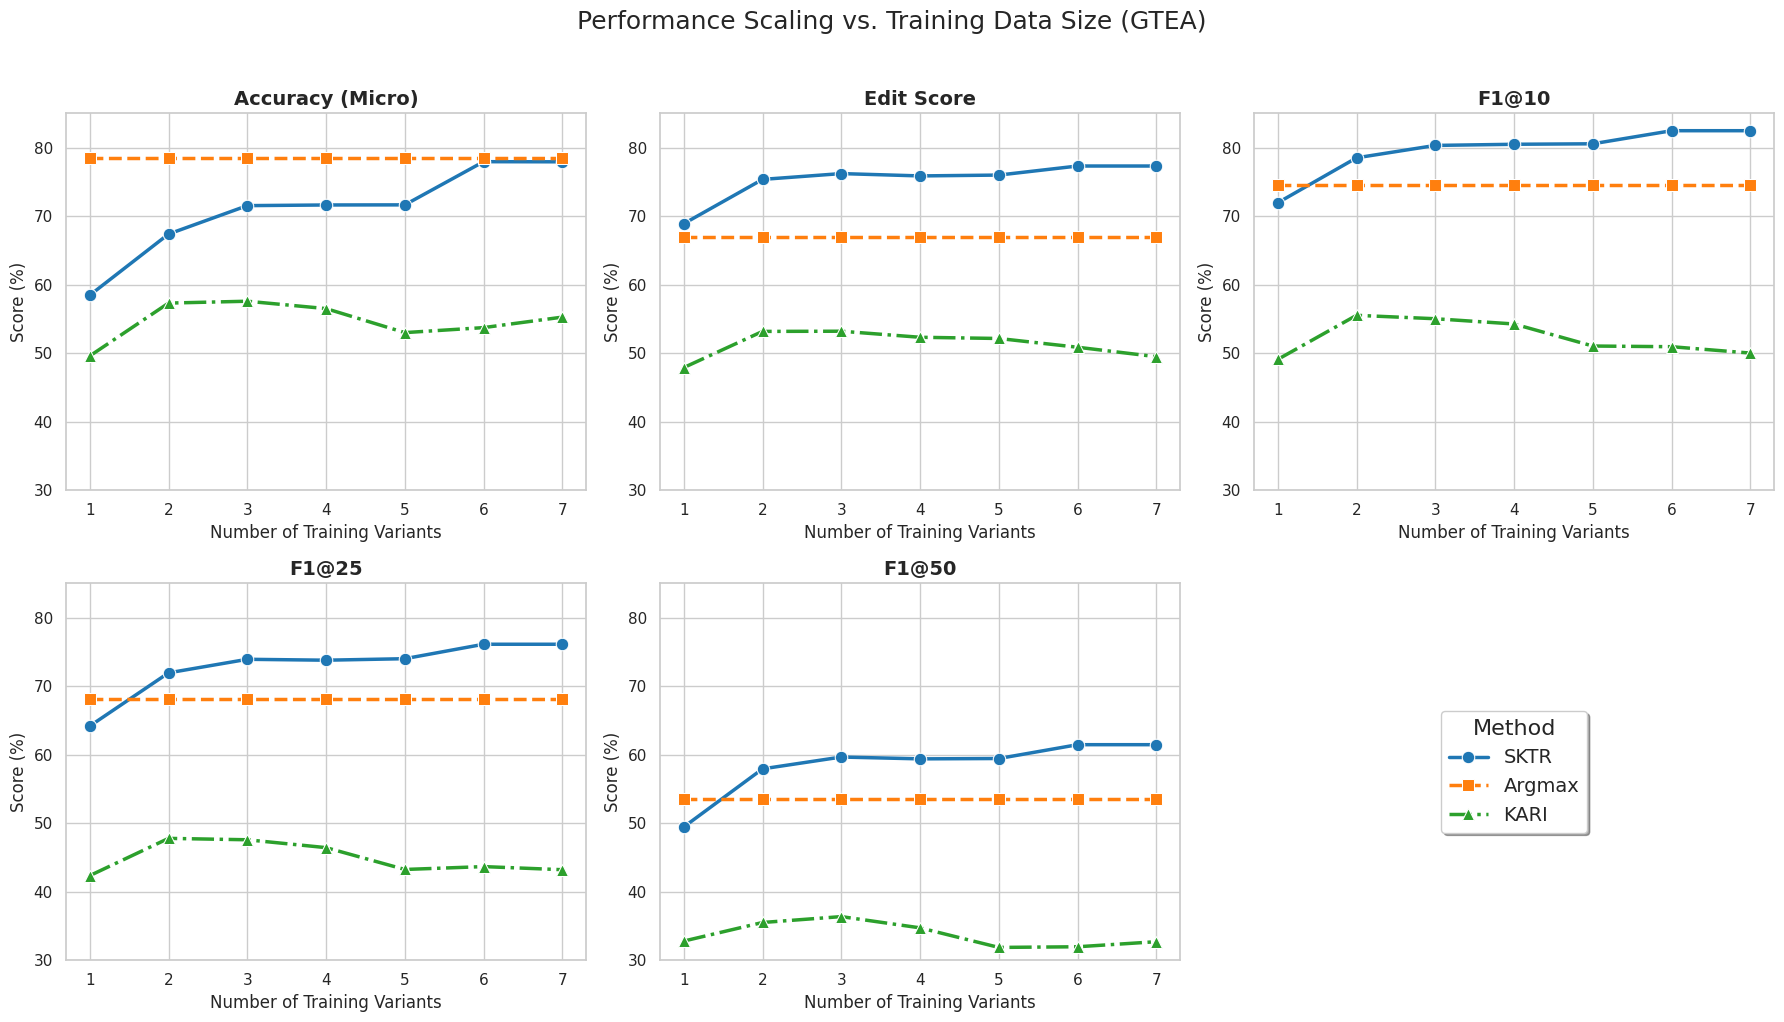

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean visual style
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Setup the figure grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Metrics configuration to loop through
metrics_config = [
    ('acc_micro', 'Accuracy (Micro)'),
    ('edit', 'Edit Score'),
    ('f1@10', 'F1@10'),
    ('f1@25', 'F1@25'),
    ('f1@50', 'F1@50')
]

# Define consistent styles for each method
method_styles = {
    'sktr':   {'color': '#1f77b4', 'marker': 'o', 'label': 'SKTR',   'linestyle': '-'},
    'argmax': {'color': '#ff7f0e', 'marker': 's', 'label': 'Argmax', 'linestyle': '--'},
    'kari':   {'color': '#2ca02c', 'marker': '^', 'label': 'KARI',   'linestyle': '-.'}
}

# Plot each metric in its own subplot
for idx, (metric_suffix, title) in enumerate(metrics_config):
    ax = axes[idx]
    
    for method, style in method_styles.items():
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            sns.lineplot(
                x=df['n_train_traces'], 
                y=df[col_name], 
                ax=ax,
                linewidth=2.5,
                markersize=9,
                **style
            )
    
    # formatting
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Training Variants')
    ax.set_ylabel('Score (%)')
    ax.set_ylim(30, 85)  # Zoomed Y axis to better show differences
    ax.set_xticks(df['n_train_traces'].unique()) # Force integer ticks
    ax.legend().remove() # We will use a shared legend instead

# Use the 6th (empty) subplot for a clear Legend
ax_legend = axes[5]
ax_legend.axis('off')
handles, labels = axes[0].get_legend_handles_labels()
ax_legend.legend(
    handles, labels, 
    loc='center', 
    title='Method', 
    fontsize=14, 
    title_fontsize=16, 
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.suptitle('Performance Scaling vs. Training Data Size (GTEA)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

# Displaying Results (50 Salads)

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display, Markdown

# Read the CSV file
csv_path = "/home/dsi/eli-bogdanov/sktr_for_long_traces/results/50salads/50salads_combined_results_with_kari.csv"
df = pd.read_csv(csv_path)
# Sort by n_train_traces to ensure lines plot in order
df = df.sort_values("n_train_traces").reset_index(drop=True)

# Define column mapping for cleaner display names
metrics_map = {
    'acc_micro': 'Acc Micro',
    'edit': 'Edit',
    'f1@10': 'F1@10',
    'f1@25': 'F1@25',
    'f1@50': 'F1@50'
}
methods = ['sktr', 'argmax', 'kari']

# 1. Prepare MultiIndex DataFrame for Detailed Results
# Structure: Index=Traces, Columns=(Metric, Method)
data_dict = {}
for metric_suffix, metric_name in metrics_map.items():
    for method in methods:
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            # The tuple key (Metric, Method) creates the hierarchical column structure
            data_dict[(metric_name, method.upper())] = df[col_name]

results_df = pd.DataFrame(data_dict)
results_df.index = df['n_train_traces']
results_df.index.name = 'Traces'

# Display Main Table
display(Markdown("### 📊 Detailed Metrics by Training Traces"))
display(results_df.round(2))

# 2. Relative Improvement vs Argmax (Summary)
improvement_rows = []
baseline = 'argmax'
compare_methods = ['sktr', 'kari']

for metric_suffix, metric_name in metrics_map.items():
    row = {'Metric': metric_name}
    baseline_col = f'{baseline}_{metric_suffix}'
    baseline_mean = df[baseline_col].mean()
    
    for method in compare_methods:
        method_col = f'{method}_{metric_suffix}'
        method_mean = df[method_col].mean()
        if baseline_mean > 0:
            imp = ((method_mean - baseline_mean) / baseline_mean * 100)
            row[f'{method.upper()} vs {baseline.upper()}'] = f"{imp:+.1f}%"
        else:
            row[f'{method.upper()} vs {baseline.upper()}'] = "N/A"
    improvement_rows.append(row)

imp_df = pd.DataFrame(improvement_rows).set_index('Metric')

display(Markdown("### 📈 Average Relative Improvement (vs Argmax)"))
display(imp_df)

# 3. Overall Ranking
all_means = {}
for method in methods:
    method_cols = [f'{method}_{suffix}' for suffix in metrics_map.keys()]
    all_means[method.upper()] = df[method_cols].mean().mean()

ranking_df = pd.DataFrame(list(all_means.items()), columns=['Method', 'Avg Score'])
ranking_df['Rank'] = ranking_df['Avg Score'].rank(ascending=False).astype(int)
ranking_df = ranking_df.sort_values('Rank').set_index('Rank')

display(Markdown("### 🏆 Overall Performance Ranking"))
display(ranking_df.round(2))

### 📊 Detailed Metrics by Training Traces

Acc Micro                 Edit                F1@10                \
            SKTR ARGMAX   KARI   SKTR ARGMAX   KARI   SKTR ARGMAX   KARI   
Traces                                                                     
1          48.47   82.2  62.48  42.87   55.9  41.45  52.62  65.67  55.86   
2          79.33   82.2  66.52  72.42   55.9  57.02  80.06  65.67  63.86   
3          79.38   82.2  60.44  72.11   55.9  50.02  79.68  65.67  62.76   
4          78.84   82.2  58.69  72.31   55.9  46.70  79.88  65.67  59.31   
5          82.15   82.2  62.02  72.10   55.9  42.46  80.31  65.67  56.94   
6          82.31   82.2  60.81  73.31   55.9  43.15  80.96  65.67  56.77   
7          82.30   82.2  63.37  73.20   55.9  44.42  81.26  65.67  57.47   
8          82.24   82.2  61.54  73.69   55.9  43.88  81.38  65.67  55.51   
9            NaN    NaN  61.20    NaN    NaN  42.51    NaN    NaN  54.70   
10         82.17   82.2  61.45  72.10   55.9  46.26  80.57  65.67  58.19   

        F1@25                F1@50                
         SKTR ARGMAX   KARI   SKTR ARGMAX   KARI  
Traces                                            
1       45.70  64.22  54.66  39.31   56.7  45.25  
2       76.79  64.22  61.60  69.39   56.7  50.95  
3       76.67  64.22  59.29  68.92   56.7  48.94  
4       76.92  64.22  55.71  68.81   56.7  43.73  
5       78.90  64.22  53.52  69.72   56.7  43.31  
6       79.54  64.22  51.76  70.30   56.7  41.09  
7       79.54  64.22  53.41  70.59   56.7  42.09  
8       79.87  64.22  51.61  70.60   56.7  41.01  
9         NaN    NaN  50.49    NaN    NaN  41.38  
10      78.94  64.22  54.65  69.86   56.7  41.73

### 📈 Average Relative Improvement (vs Argmax)

,SKTR vs ARGMAX,KARI vs ARGMAX
Metric,,
Acc Micro,-5.8%,-24.8%
Edit,+24.0%,-18.1%
F1@10,+17.9%,-11.5%
F1@25,+16.4%,-14.9%
F1@50,+17.1%,-22.5%


### 🏆 Overall Performance Ranking

,Method,Avg Score
Rank,,
1,SKTR,73.07
2,ARGMAX,64.94
3,KARI,52.88


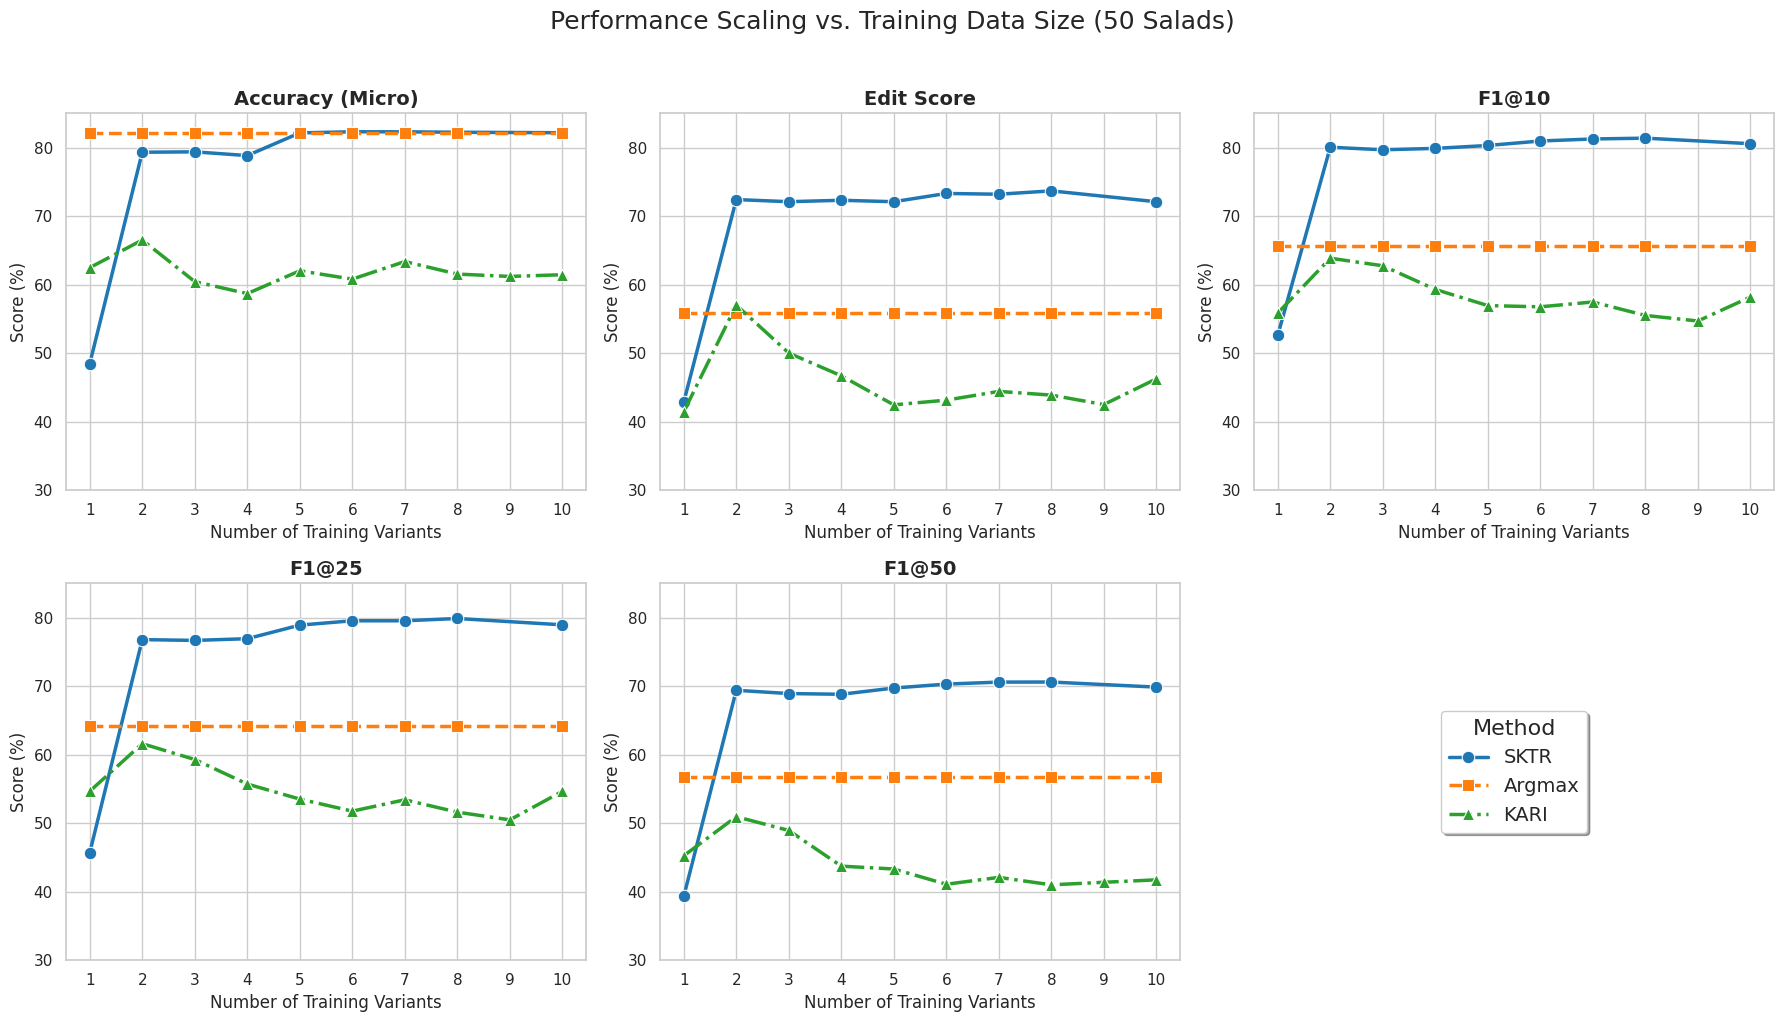

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean visual style
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Setup the figure grid (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Metrics configuration to loop through
metrics_config = [
    ('acc_micro', 'Accuracy (Micro)'),
    ('edit', 'Edit Score'),
    ('f1@10', 'F1@10'),
    ('f1@25', 'F1@25'),
    ('f1@50', 'F1@50')
]

# Define consistent styles for each method
method_styles = {
    'sktr':   {'color': '#1f77b4', 'marker': 'o', 'label': 'SKTR',   'linestyle': '-'},
    'argmax': {'color': '#ff7f0e', 'marker': 's', 'label': 'Argmax', 'linestyle': '--'},
    'kari':   {'color': '#2ca02c', 'marker': '^', 'label': 'KARI',   'linestyle': '-.'}
}

# Plot each metric in its own subplot
for idx, (metric_suffix, title) in enumerate(metrics_config):
    ax = axes[idx]
    
    for method, style in method_styles.items():
        col_name = f'{method}_{metric_suffix}'
        if col_name in df.columns:
            sns.lineplot(
                x=df['n_train_traces'], 
                y=df[col_name], 
                ax=ax,
                linewidth=2.5,
                markersize=9,
                **style
            )
    
    # formatting
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Number of Training Variants')
    ax.set_ylabel('Score (%)')
    ax.set_ylim(30, 85)  # Zoomed Y axis to better show differences
    ax.set_xticks(df['n_train_traces'].unique()) # Force integer ticks
    ax.legend().remove() # We will use a shared legend instead

# Use the 6th (empty) subplot for a clear Legend
ax_legend = axes[5]
ax_legend.axis('off')
handles, labels = axes[0].get_legend_handles_labels()
ax_legend.legend(
    handles, labels, 
    loc='center', 
    title='Method', 
    fontsize=14, 
    title_fontsize=16, 
    frameon=True,
    fancybox=True,
    shadow=True
)

plt.suptitle('Performance Scaling vs. Training Data Size (50 Salads)', fontsize=18, y=1.02)
plt.tight_layout()
plt.show()